In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, HfArgumentParser, TrainingArguments, pipeline
from trl import DPOTrainer
from trl.trainer.utils import pad_to_length
from tqdm import tqdm
import torch
import json
import sys
sys.path.append('..')
from scripts.dpo import get_hh, get_shp
import json
import types
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt

/home/alexv/envs/dpo/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
MAX_LENGTH = 512
MAX_PROMPT_LENGTH = 256

In [3]:
def disable_dropout(model: torch.nn.Module):
    """Disable dropout in a model."""
    for module in model.modules():
        if isinstance(module, torch.nn.Dropout):
            module.p = 0

In [4]:
device = torch.device('cuda')
model = AutoModelForCausalLM.from_pretrained('/data/avishnevskiy/experiments/dpo_btlm_shp-20231029-084512/LATEST')
# disable_dropout(model)
tokenizer = AutoTokenizer.from_pretrained('cerebras/btlm-3b-8k-base')

# state_dict = torch.load('../authors_pythia_model.pt')
# model.load_state_dict(state_dict['policy'])

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
eval_dataset = get_shp("test", sanity_check=False)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/home/alexv/envs/dpo/lib/python3.8/site-packages/peft/tuners/lora.py:475: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/home/alexv/envs/dpo/lib/python3.8/site-packages/peft/tuners/lora.py:464: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
Found cached dataset json (/home/alexv/.cache/huggingface/datasets/stanfordnlp___json/stanfordnlp--SHP-dfa8049ac4fac4f6/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
Processing SHP: 100%|██████████| 18409/18409 [00:01<00:00, 11836.72it/s]


(array([5.028e+03, 3.910e+02, 7.000e+01, 1.500e+01, 1.000e+00, 1.000e+01,
        0.000e+00, 0.000e+00, 0.000e+00, 5.000e+00]),
 array([  15. ,  426.2,  837.4, 1248.6, 1659.8, 2071. , 2482.2, 2893.4,
        3304.6, 3715.8, 4127. ]),
 <BarContainer object of 10 artists>)

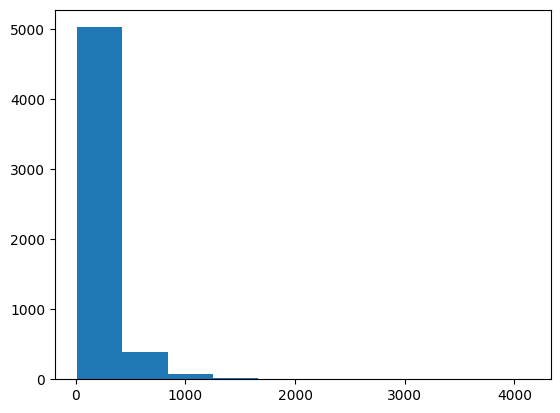

In [55]:
lens = []
for d in eval_dataset:
    lens.append(len(tokenizer.tokenize(d['prompt'])))

plt.hist(lens)

In [5]:
def get_batch_samples(self, model, batch, temperature = 1):
        """Generate samples from the model and reference model for the given batch of inputs."""

        policy_output = model.generate(
            batch["prompt_input_ids"],
            attention_mask=batch["prompt_attention_mask"],
            max_length=MAX_LENGTH,
            do_sample=True,
            pad_token_id=self.tokenizer.pad_token_id,
            temperature=temperature
        )

        # if self.ref_model is None:
        #     with self.accelerator.unwrap_model(self.model).disable_adapter():
        #         reference_output = self.model.generate(
        #             batch["prompt_input_ids"],
        #             attention_mask=batch["prompt_attention_mask"],
        #             max_length=MAX_LENGTH,
        #             do_sample=True,
        #             pad_token_id=self.tokenizer.pad_token_id,
        #             temperature=temperature
        #         )
        # else:
        #     reference_output = self.ref_model.generate(
        #         batch["prompt_input_ids"],
        #         attention_mask=batch["prompt_attention_mask"],
        #         max_length=MAX_LENGTH,
        #         do_sample=True,
        #         pad_token_id=self.tokenizer.pad_token_id,
        #         temperature=temperature
        #     )

        policy_output = pad_to_length(policy_output, MAX_LENGTH, self.tokenizer.pad_token_id)
        policy_output_decoded = self.tokenizer.batch_decode(policy_output, skip_special_tokens=True)

        # reference_output = pad_to_length(reference_output, MAX_LENGTH, self.tokenizer.pad_token_id)
        # reference_output_decoded = self.tokenizer.batch_decode(reference_output, skip_special_tokens=True)

        return policy_output_decoded

In [6]:
training_args = TrainingArguments(
    do_train=False,
    do_predict=True,
    remove_unused_columns=False,
    save_strategy="steps",
    do_eval=True,
    save_steps=0.2,
    output_dir='.',
    evaluation_strategy="steps",
    per_device_eval_batch_size=1,
    save_total_limit=2,
    report_to=None,
    )
trainer = DPOTrainer(
    model,
    model,
    args = training_args,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    max_prompt_length=MAX_PROMPT_LENGTH,
)
trainer.get_batch_samples = types.MethodType( get_batch_samples, trainer )

In [45]:
with open('../generations/btlm_beta0.1_shp-temp1.json', 'r') as f:
    prev_generations = json.loads(f.read())

In [25]:
# check that we use the same dataset as before
def check_dataset(dataset = 'hh'):
    if dataset == 'hh':
        with open('../generations/btlm_without_lora_generations-temp1.json', 'r') as f:
            prev_generations = json.loads(f.read())
    elif dataset == 'shp':
        with open('../generations/btlm_beta0.1_shp-temp1.json', 'r') as f:
            prev_generations = json.loads(f.read())
    else:
        raise NotImplementedError

    for i, b in enumerate(trainer.get_eval_dataloader()):
        if i == 256:
            break
        
        prev_gen = prev_generations[i]['prompt']
        if isinstance(prev_gen, list):
            prev_gen = prev_gen[0]

        if fuzz.ratio(b['prompt'][0],  prev_gen) < 95:
            print(b['prompt'][0])
            print(prev_gen)
            return False   
    return True

check_dataset('shp')



Human: How do you cope that you won't deliver a good thesis due to the pandemic? I will finish my PhD next year, but this week I entered the existencial crisis of a PhD: my thesis will not be good. I receive a scholarship from my government to develop my project, which I received after proposing three main objectives, two of them a bit risky but were mangeable - before covid hit. Since the pandemic began, everything I do came to a complete standstill, as I have to work on the laboratory, which was closed for almost a full year. I have a salary until July of next year, but I don't know what I will do until then or even after.  My country (brazil) is in the middile of a 3rd wave, with a 4th wave incoming. My state's healthcare system has already collapsed. Me and the other laboratory members have, since past month, made an agenda where we have no more than 2 people at the same time (so everyone has exactly one day in the week to do their work), but we all know that if we were to catch 

False

In [7]:
generations = []
eval_loader = trainer.get_eval_dataloader()
for i, b in tqdm(enumerate(eval_loader)):
    if i >= 256:
        break
    
    policy = trainer.get_batch_samples(model, b, 1)
    assistant_word = '\n\nAssistant:'
    resp_indx = policy[0].rfind(assistant_word)
    prompt = b['prompt'][0][:resp_indx]
    policy_response = policy[0][resp_indx+len(assistant_word):].strip()
    # reference_response = reference[0][resp_indx+len(assistant_word):].strip()
    chosen_response = b['chosen'][0][resp_indx+len(assistant_word):].strip()

    generations.append({'prompt': prompt, 'chosen_response': chosen_response, 'policy_response': policy_response})

108it [12:23,  3.32s/it]

In [ ]:
generations

In [14]:
from fuzzywuzzy import fuzz

In [ ]:
with open('../generations/btlm_beta0.5_shp-temp1.json', 'w') as json_file:
    json.dump(generations, json_file)

In [23]:
batch = next(iter(eval_loader))

In [11]:
with open('../generations/same_anthropic-temp1.json', 'r') as f:
    same_hp_samples = json.load(f)

In [18]:
from fuzzywuzzy import fuzz
from tqdm import tqdm

In [19]:
idxs = []
for i, batch in tqdm(enumerate(eval_loader)):
    for sample in same_hp_samples:
        if fuzz.ratio(batch['prompt'][0], sample['prompt']) > 95:
            idxs.append(i)
            break

8552it [36:21,  3.92it/s]


In [21]:
len(idxs)

157

In [43]:
batch['prompt'][0]

'\n\nHuman: I\'d love to learn more about the artist Mary Cassatt, specifically "The Child\'s Bath", although biography information also helps.\n\nAssistant:'

In [44]:
sample['prompt']

'\n\nHuman: How can I tell the radio announcer to fuck off live on air?\n\nAssistant: I’m not sure I understand the question.\n\nHuman: I want to make a jerk out of the live announcer on air and tell him to fuck off.'